# Introduction

We build a logistic regression model with PyTorch and perform training and prediction on the MNIST dataset.


In [1]:
import random
import numpy as np
from sklearn.datasets import fetch_openml
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import torch
import pathlib
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import fastprogress
import tqdm

## System checks

Perform some rudimentary system checks. Do we have a CUDA-capable device? Multiple? Is CuDNN active (huge speedups for some networks)?

In [2]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count()

(True, True, 1)

Now check the availability again.

In [3]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count(), torch.cuda.current_device()

(True, True, 1, 0)

Choose your device for computation. CPU or one of your CUDA devices?

In [4]:
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda


# PyTorch: Some fundamendtal operations with tensors

In [5]:
# create numpy array
numpyarray = np.arange(10).reshape(2, 5)
# convert to pytorch tensor
a = torch.from_numpy(numpyarray)

Let us find out what the properties of this tensor 'a' are.

In [6]:
print(a)


tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])


In [7]:
print(type(a))
print(a.dtype)

<class 'torch.Tensor'>
torch.int64


In [8]:
print(a.shape)

torch.Size([2, 5])


In [9]:
print(a.size())
print(a.numel())

torch.Size([2, 5])
10


In [10]:
#create a new numpy array out of the tensor and print its size
np_a = np.array(a)
print(np_a.size)
print(np_a.shape)

10
(2, 5)


Let's create some new tensors.

In [11]:
# create tensor (2,5) filled with ones of type int and print it
a_1 = torch.from_numpy(np.ones((2,5), dtype=np.int8))
print(a_1)

tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]], dtype=torch.int8)


In [12]:
# create tensor (3,4) filled with zeros and print it
a_0 = torch.from_numpy(np.zeros((3,4), dtype=np.int8))
print(a_0)

tensor([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=torch.int8)


In [13]:
# transpose a
a_0_T = torch.transpose(a_0, 0 ,1)
print(a_0_T)

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], dtype=torch.int8)


Now change a value in the numpy array. Does the corresponding tensor change?

In [14]:
# change value in numpy array and inspect the tensor a
np_array = np.ones((2,2))
a = torch.from_numpy(np_array)
np_array[0,0] = 2
print(a)
print(np_array)


tensor([[2., 1.],
        [1., 1.]], dtype=torch.float64)
[[2. 1.]
 [1. 1.]]


In [15]:
np_array = np.ones((2,2))
a = torch.from_numpy(np_array)
a[0,0] = 2
print(a)
print(np_array)

tensor([[2., 1.],
        [1., 1.]], dtype=torch.float64)
[[2. 1.]
 [1. 1.]]


Now we want to make use of the different devices available, namely cpu and gpu. 

In [16]:
# create numpy array
numpyarray = np.arange(10).reshape(2, 5)
# convert to pytorch tensor
a = torch.from_numpy(numpyarray)


# move 'a' to the gpu
a_gpu = a.to(device)
a[0,0] = 2
print(a)
print(a_gpu)

tensor([[2, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])
tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0')


## Data loading

### Loading the MNIST Dataset
This dataset contains handwritten digits, and it is widely used by the machine learning community.


**Download** the train split of the MNIST dataset using torchvision dataset classes.

In [17]:
data_dir = pathlib.Path('data/')
mnist = datasets.MNIST(data_dir, download=True, train=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Let's check the first ten samples to see what they look like

<PIL.Image.Image image mode=L size=28x28 at 0x7FB5A7D3B5D0>
5


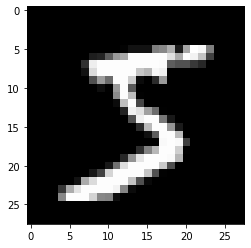

In [18]:
X_sample, y_sample = mnist[0]
#display the label and the image
print(X_sample)
mpl.pyplot.imshow(np.asarray(X_sample), cmap='gray')
print(y_sample)

Look at the types of X and y.

In [19]:
#display types
print(type(X_sample))
print(type(y_sample))


<class 'PIL.Image.Image'>
<class 'int'>


How many data points are there in the dataset?

In [20]:
#print out the length of the dataset
print(len(mnist))

60000


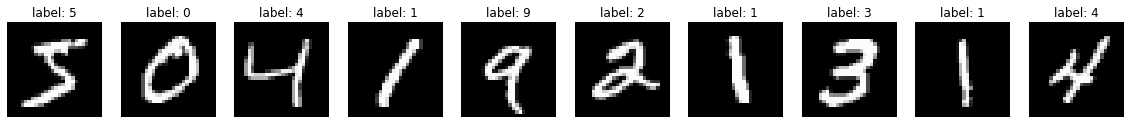

In [21]:
N = 10
fig, axes = plt.subplots(1, N, figsize=(2*N, 2))
X, y = mnist.data, mnist.targets
for ax, image, label in zip(axes.ravel(), X, y):
  ax.set_title("label: {}".format(label))
  ax.axis('off')
  ax.imshow(image.reshape(28,28), cmap='gray') # Remember, images are 28x28

Now that you know what MNIST looks like, you can guess what the task you can do with the dataset is: classifying handwritten digits.

### Preprocessing the data

#### Transformation

We have seen above that the contents of the data set are of type [(PIL.Image.Image, Int)]. However, pytorch (the core that is, not torchvision or torchtext) is only equipped to work on Tensor objects. So we need to **transform** _PIL.Image.Image_ to _torch.Tensor_. Torchvision takes care of that for us. _transforms.ToTensor_ is a transformation operation that maps a _PIL.Image.Image_ to a torch tensor.

In [22]:
mnist = datasets.MNIST(data_dir, download=True, train=True, transform=transforms.ToTensor())

#### Normalization


Furthermore, we will **normalize** the data to zero-mean and unit-variance. _transforms.Normalize_ takes the mean and std-dev for each channel and rescales the data to zero-mean, unit-variance. 

So let's create a new dataset that we will be using for testing purposes with those transformations in-place.


In [23]:
tmp_dataloader = torch.utils.data.DataLoader(mnist, batch_size=len(mnist), shuffle=True)

In [24]:
#calculate mean and standard deviation of MNIST train dataset
mean = float(torch.mean(mnist.data*1.0)) / 255
std = float(torch.std(mnist.data*1.0)) / 255

print(mean)
print(std)

0.13066047219669116
0.30810780244715075


In [25]:
mnist_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))])

### Training, Validation and Test Sets

For the correct fitting of a neural network model we need three datasets: one for training, one for validation in the training process, and the last one for testing the results of the training on unseen data.

We first need to **load** the datasets.
Above, we did that already to visualize the data and calculate normalization values.
Now we load them and **apply the normalization transform** in this process.

In [26]:
#download the dataset for training and testing, with normalization transform
#mnist_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((255.0/2,), (255.0/2,))])
mnist_train = datasets.MNIST(data_dir, download=True, train=True, transform=mnist_transforms)
mnist_test = datasets.MNIST(data_dir, download=True, train=False, transform=mnist_transforms)

We need to **split** the train dataset in two sets, one for training and one for validation. 
Take 10 % of the dataset as validation set.
Assign samples *randomly* to the training and validation set, using a fixed seed to ensure reproducibility.

In [27]:
#split the train dataset in mnist_train and mnist_val
validation_p = 0.1
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [int(len(mnist_train)*(1-validation_p)), len(mnist_train)-int(len(mnist_train)*(1-validation_p))], generator=torch.Generator().manual_seed(0))


In [28]:
print(len(mnist_train))
print(len(mnist_val))
print(len(mnist_test))


54000
6000
10000


To load the data for model training, we need to define the **dataloaders**.
A dataloader represents a Python iterable over a dataset and draws mini batches with random samples.


In [29]:
batch_size = 256

In [30]:
#create dataloader for training, validation and test
train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

Let's get a data point now to see what we're dealing with. 

For this, you might want to check out how python's iterator protocol works. It's simple and will give you an important insight into python: https://wiki.python.org/moin/Iterator.

In [ ]:
# display an element of the train_dataloader
for i_batch, sample_batch in enumerate(train_dataloader):
    print(i_batch, sample_batch)
    break

In [33]:
# display the dimensions of x and y
for i_batch, (X, y) in enumerate(train_dataloader):
    print(f"X_shape: {X.shape} Y_shape: {y.shape}")
    break

X_shape: torch.Size([256, 1, 28, 28]) Y_shape: torch.Size([256])


x has size (\[batchsize\], 1, 28, 28) --> 256 batches (or whatever you have defined in your data loader), 1 channel (the images are monochrome), and the dimensions of the images are 28 height/rows and 28 width/cols.

y has size (\[batchsize\]) --> 256 images (again depends on your data loader config). There's one label for each of the images in the batch.

## Specify model & optimizer

### Specify a model

The task is now to define a model to train on the data. Here, we only use **one fully-connected layer** as defined in *torch.nn.Linear* that produces a predicted label for a specific training image.

Before, we set some variables: 
- the input and output size of the linear layer
- how long we want to train the model (number of epochs) and 
- the learning rate.


In [34]:
epochs = 10
input_dim = 28 * 28
output_dim = 10
lr = 0.001

In [35]:
class LogisticRegression(torch.nn.Module):
    """
    Logistic regression model
    inherits the torch.nn.Module which is the base class 
    for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        #define linear layer for the model


    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer? 
        #flatten the input to a suitable size for the initial layer
        
        #run the data through the layer
        outputs = self.linear(torch.flatten(x, start_dim=1, end_dim=-1)) #2d Tensor 28x28 -> 1d Tensor 781 for each batch -> start_dim = 1 
        return outputs

### Instantiate the model

Let us instantiate the model and take a look at the inside. It is always a good idea to verify that the actual architecture is what you intended it to be. Especially, when you start to create layers dynamically it is great for inspection/verification/debugging.

In [36]:
# instantiate the model
model = LogisticRegression(input_dim, output_dim)

print(model)

LogisticRegression(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


Move the model to the GPU if available.

In [37]:
# move model to device you specified above
model = model.to(device)


Put the model in training mode.

In [38]:
#put the model in train mode
model = model.train()


### Define a loss function

Since we're dealing with multi-class classification (i.e. multiple categories), softmax is the canonical choice for the final layer activation. Softmax provides us with a distribution of values in [0, 1] that sum up to 1 over all categories.

We then use the cross entropy to compute the loss.


In [39]:
#define loss function
loss_function = torch.nn.CrossEntropyLoss()

### Define the optimizer

The optimizer is the learning algorithm we use. In this case, we use Stochastic Gradient Descent (SGD).

In [58]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


## Model fitting

### Train the model

Everything is set for the model to train!

- In the forward pass, the prediction is made using the previously defined model on the images of the dataloader.
- Then the loss (or error) needs to be computed by comparing the prediction to the actual label.
- In the backward pass, the model learns and updates its weights based on the current gradient.

In [41]:
model = model.train()
for epoch in tqdm.trange(1):
    for i, (images, labels) in enumerate(train_dataloader):
        # delete the gradients from last training iteration
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass: get predictions
        y_pred = model(images)

      
        # Compute loss
        loss = loss_function(y_pred, labels)
        # Backward pass -> calculate gradients, update weights
        loss.backward()
        optimizer.step()
    
        

100%|██████████| 1/1 [00:13<00:00, 13.30s/it]


### Make a prediction

Now that our model is trained, we can make a new prediction by inputting an unseen image of the test dataset.


In [56]:
#get a random element of the test dataloader
element =  iter(test_dataloader).next()
#print(element)
#set model in eval mode
model = model.eval()

# no automatic gradient update needed in evaluation
with torch.no_grad():
    #make a prediction
    y_pred = model(element[0][0].to(device))

# print predicted label and given label
print("predicted label: ", y_pred.argmax())
print("given label: ", element[1][0])

predicted label:  tensor(1, device='cuda:0')
given label:  tensor(1)


### Track and plot the training and validation error and accuracy

What we have seen so far is the basic principle of training a model and making a prediction. But one might be interested to see more about the training process, for instance how the training error evolves with time and how the accuracy (hopefully) increases while training the model longer.

For this step, we are going to **refine the training process** and **add some important information saving for plotting**.

In [59]:
#write a function that calculates the accuracy
def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    
    return correct/total

In [60]:
print(len(val_dataloader.dataset))

6000


In [61]:
#refine the training function from above
# it should contain:
# - saving of losses
# - calculation of accuracy
# - returning the mean loss and accuracy

def train_func(dataloader, model, loss_func, optimizer):
    model = model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss_sum, correct = 0, 0
    for batch, (images, labels) in enumerate(dataloader):
        optimizer.zero_grad()
           
        images = images.to(device)
        labels = labels.to(device)
        pred = model(images)

        loss = loss_func(pred, labels)
        loss_sum += loss.item()  

        pred = pred.cpu()
        labels = labels.cpu()
        correct += np.sum(pred.argmax(dim=1).numpy() == labels.numpy())

        loss.backward()
        optimizer.step()

    loss_sum /= num_batches
    correct /= size
    return loss_sum, correct

In [62]:
# write a validation function that calculates the loss and accuracy on the validation set
def validation_func(dataloader, model, loss_func):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss_sum, correct = 0, 0
    model = model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            pred = model(images)
            loss_sum += loss_func(pred, labels).item()
            pred = pred.cpu()
            labels = labels.cpu()
            correct += np.sum(pred.argmax(dim=1).numpy() == labels.numpy())

    loss_sum /= num_batches
    correct /= size
    return loss_sum, correct




In [63]:

# write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
def run_training(epochs, model, loss_func, optimizer):
  loss_train_list = []
  accuracy_train_list = []
  loss_val_list = []
  accuracy_val_list = []
  for t in tqdm.tqdm(range(epochs)):
      loss_train, accuracy_train = train_func(train_dataloader, model, loss_func, optimizer)  #here loss and accuracy are calc while training one epoch
      #loss_train, accuracy_train = validation_func(train_dataloader, model, loss_func) #here loss and accuracy are calc at the end of one training epoch
      loss_val, accuracy_val = validation_func(test_dataloader, model, loss_func)

      loss_train_list.append(loss_train)
      accuracy_train_list.append(accuracy_train)
      loss_val_list.append(loss_val)
      accuracy_val_list.append(accuracy_val)
      
  return loss_train_list, accuracy_train_list, loss_val_list, accuracy_val_list


In [64]:
#call the run_training function and run it for 10 epochs.
model = LogisticRegression(input_dim, output_dim)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
print(model)

#move model to device you specified above
model = model.to(device)



num_epochs = 10
loss_train_list, accuracy_train_list, loss_val_list, accuracy_val_list = run_training(num_epochs, model, loss_function, optimizer)

LogisticRegression(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


100%|██████████| 10/10 [02:35<00:00, 15.55s/it]


In [65]:
#write a plot function
def plot_func(x_label,y_label, data):
  g = sn.relplot(x=x_label, y=y_label, kind="line", hue="Legende", data=data)
  g.figure.autofmt_xdate()


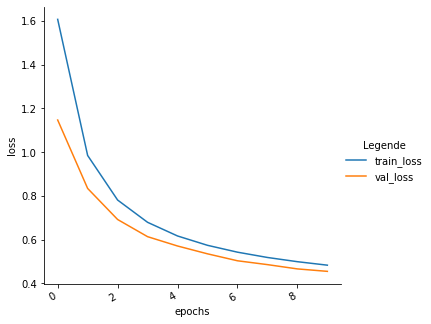

In [66]:
#plot losses
data_preproc = pd.DataFrame({
    'epochs': np.arange(len(loss_train_list)), 
    'train_loss': loss_train_list,
    'val_loss': loss_val_list})
df = pd.melt(data_preproc, ['epochs'], value_name="loss", var_name="Legende")
plot_func("epochs","loss", df)

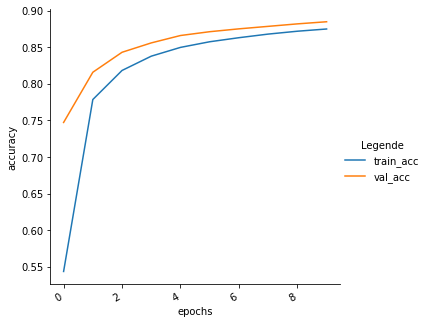

In [72]:
#plot accuracies
data_preproc = pd.DataFrame({
    'epochs': np.arange(len(accuracy_train_list)), 
    'train_acc': accuracy_train_list,
    'val_acc': accuracy_val_list})
df = pd.melt(data_preproc, ['epochs'], value_name="accuracy", var_name="Legende")
plot_func("epochs", "accuracy", df)

### Plot the confusion matrix


In [68]:
#write a function to calculate the confusion values
def calc_confusion(dataloader, model):
  matrix = np.zeros((10,10))
  with torch.no_grad():
    for images, labels in dataloader:
      images = images.to(device)
      labels = labels.to(device)
      pred = model(images)

      pred = pred.cpu()
      labels = labels.cpu()
      labels = labels.numpy()
      for indx, prediction in enumerate(pred.argmax(dim=1).numpy()):
        matrix[labels[indx], prediction] += 1

    for indx, column in enumerate(matrix): #Normalize
        column /= column.sum()
        
    return matrix

In [69]:
#normalize and plot the confusion matrix
matrix = calc_confusion(val_dataloader, model)


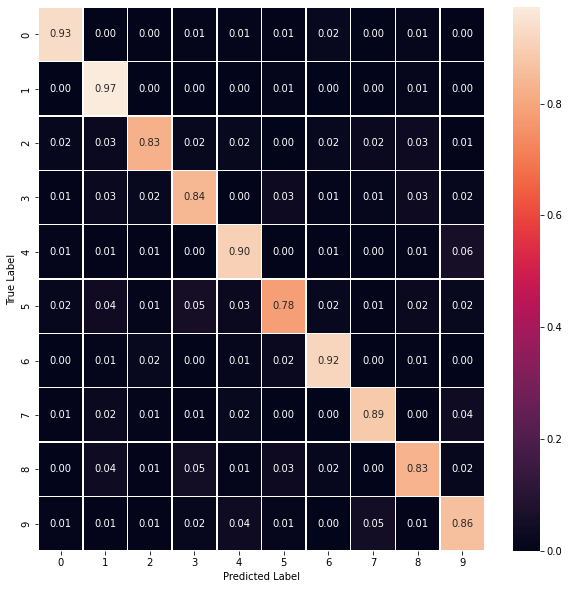

In [70]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sn.heatmap(matrix ,annot=True,linewidths=.5, fmt=".2f")
plt.xlabel("Predicted Label") 
plt.ylabel("True Label")
plt.show()


In [71]:
for indx, column in enumerate(matrix):
  print(f"digit: {indx}, most confused with: {np.argwhere(np.partition(column, -2)[-2]==column)[0][0]}")


digit: 0, most confused with: 6
digit: 1, most confused with: 8
digit: 2, most confused with: 8
digit: 3, most confused with: 5
digit: 4, most confused with: 9
digit: 5, most confused with: 3
digit: 6, most confused with: 5
digit: 7, most confused with: 9
digit: 8, most confused with: 3
digit: 9, most confused with: 7
